Author: Sophie-Christine Porak / ChatGPT

This script will count the number of tiles per protein segment therefore serving as an estimate of overall diversity at different protein regions. 
The absolute tile counts are being represented as a plot (in the second code block), where on the x-axis we have the position of the protein (amino acid position) and on the 
y-axis we have the absolute count of tiles for that position.

As the input is a nucleotide sequence, it needs to be translated to represent the amino acid sequence (or just divide by 3, I also know that each tile
represents 46 amino acids). 

Input: 
The headers should look the followingL 
>WFG38034.1_1_1
ATGGGGGATATCATCTCGTTT-nt sequence-

In [11]:
from Bio import SeqIO #for parsing GenBank records
from Bio import Entrez #for accessing NCBI databases
from collections import defaultdict #convenient nested dictionary
import re #regular expression to parse headers
import csv
import os 

target_organism = "mammarenavirus lassaense"

Entrez.email = "email.edu" #required for ncbi access

fasta_file = '0.96_tiling_out_nt_tiles_cp_cleaned_no_linkers_only_accession_with_tile_number_052925.fasta'
base_output_dir = 'tile_diversity_060325'

#ensure output dir exists
os.makedirs(base_output_dir, exist_ok=True)

output_csv = os.path.join(base_output_dir,"tile_data_with_sequence.csv")
counts_csv = os.path.join(base_output_dir, "tile_position_counts.csv")
skipped_log = os.path.join(base_output_dir, "skipped_headers.log")

#store lookup results to avoid redundant API calls - this serves to cache results so each NCBI accession is fetched only once
accession_lookup = {}
#create a dictionary {(protein, organism): {tile_position: count}} 
tile_counts = defaultdict(lambda: defaultdict(int))
tile_rows = []
skipped_headers = []


#-------- FUNCTIONS --------

#function to fetch protein name and organism from NCBI
def fetch_info(accession):
    if accession in accession_lookup:
        #if accession already fetched it returns from the cache
        return accession_lookup[accession]

    try: 
        #downloads and parses the GenBank record from NCBI
        handle = Entrez.efetch(db="protein", id=accession, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        handle.close()

        organism = record.annotations.get("organism", "unknown") #get the organism name
        protein_name = "unknown"

        #first trying to find product in CDS feature 
        for feature in record.features:
            if feature.type == "CDS" and "product" in feature.qualifiers:
                protein_name = feature.qualifiers["product"][0]
                break
        
        else:
            #if no CDS/product found, look in the protein feature
            for feature in record.features:
                if feature.type == "Protein" and "product" in feature.qualifiers:
                    protein_name = feature.qualifiers["product"][0]
                    break

        accession_lookup[accession] = (protein_name, organism)
        return protein_name, organism

    except Exception as e:
        print(f"Failed to fetch {accession}: {e}")
        accession_lookup[accession] = ("unknown", "unknown")
        return "unknown", "unknown"



# Process FASTA file
for record in SeqIO.parse(fasta_file, "fasta"):
    header = record.id
    sequence = str(record.seq)

    match = re.match(r"([\w.]+)_(\d+)_(\d+)", header)
    if not match:
        print(f"Skipped header: {header}")
        skipped_headers.append(header)
        continue

    accession, tile_pos, _ = match.groups()
    tile_pos = int(tile_pos)

    protein, organism = fetch_info(accession)

    # Store full data row
    tile_rows.append([accession, tile_pos, protein, organism, sequence])

    # Count occurrences
    tile_counts[(protein, organism)][tile_pos] += 1

if skipped_headers:
    with open(skipped_log, "w") as f:
        for header in skipped_headers:
            f.write(header + "\n")

# Write full tile data with sequence
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Accession", "Tile Position", "Protein", "Organism", "Sequence"])
    writer.writerows(tile_rows)

# Write summary count table
with open(counts_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Protein", "Organism", "Tile Position", "Tile Count"])

    for (protein, organism), positions in tile_counts.items():
        for pos, count in sorted(positions.items()):
            writer.writerow([protein, organism, pos, count])

Skipped header: AAC82596.1|_1_1
Skipped header: AAC82596.1|_2_1
Skipped header: AAC82596.1|_3_1
Skipped header: AAC82596.1|_4_1
Skipped header: AAC82596.1|_1_1
Skipped header: AAC82596.1|_2_1
Skipped header: AAC82596.1|_3_1
Skipped header: AAC82596.1|_4_1
Skipped header: PF3D7_0801000.1-p1|transcript=PF3D7_0801000.1|gene=PF3D7_0801000|organism=Plasmodium_falciparum_3D7|gene_product=Plasmodium_exported_protein_(PHISTc),_unknown_function|transcript_product=Plasmodium_exported_protein_(PHISTc),_unknown_function|location=Pf3D7_08_v3:84568-88422(-)|protein_length=1219|sequence_SO=chromosome|SO=protein_coding_seq22_1_1
Skipped header: PF3D7_0501400.1-p1|transcript=PF3D7_0501400.1|gene=PF3D7_0501400|organism=Plasmodium_falciparum_3D7|gene_product=interspersed_repeat_antigen|transcript_product=interspersed_repeat_antigen|location=Pf3D7_05_v3:74509-79842(+)|protein_length=1720|sequence_SO=chromosome|SO=protein_coding_seq56_1_1
Skipped header: PF3D7_0220000.1-p1|transcript=PF3D7_0220000.1|gene=P

In the next block of code the input file will be tile_position_counts.csv. You will then be asked by which Organism you want to get tile count statistics on. You can also specify by protein. The output will be a barplot where the x axis is the tile position and the y axis the tile count. 

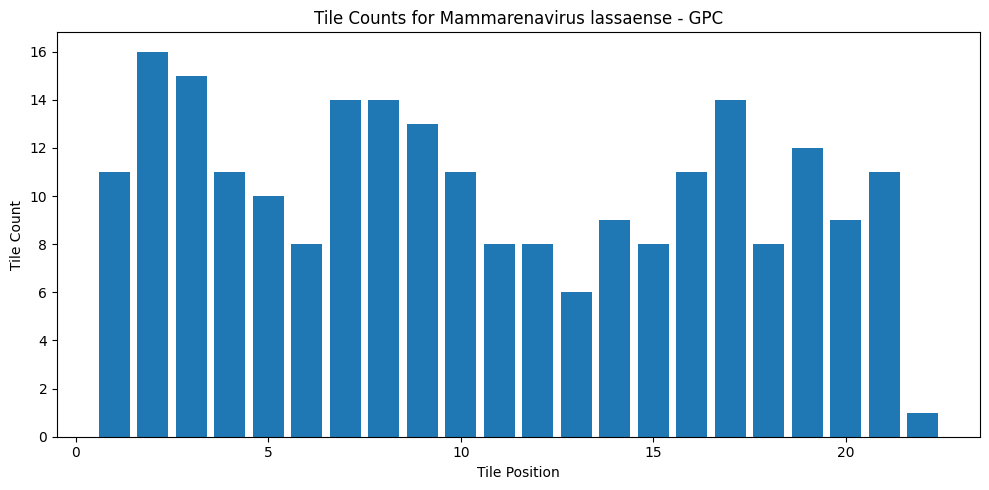

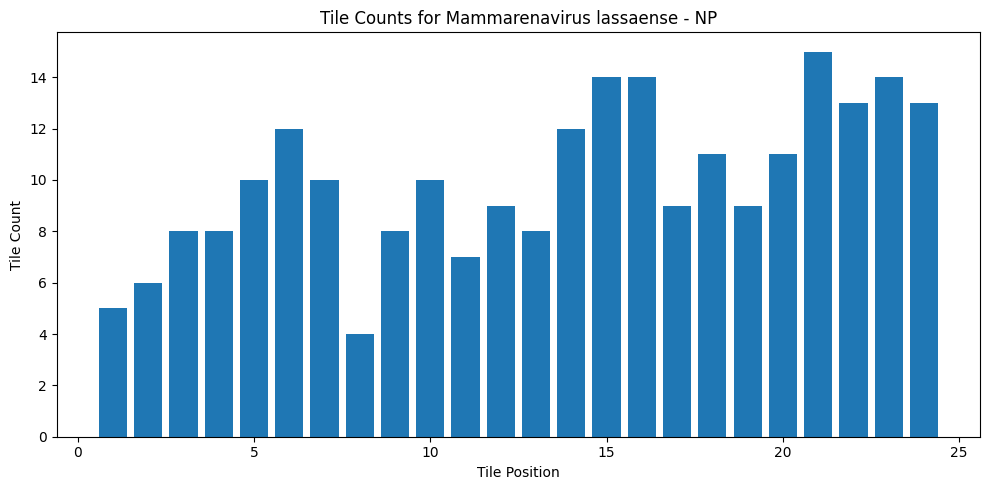

No data found for organism Mammarenavirus lassaense with protein L Protein
No data found for organism Mammarenavirus lassaense with protein Z Protein


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#define renaming map to normalize protein names - here for mammarenavirus lassaense
protein_rename_map = {
    "L protein": "L protein",
    "polymerase": "L protein",
    "RNA-directed RNA polymerase": "L protein",
    "RNA dependent-RNA polymerase": "L protein",
    "RNA-dependent RNA polymerase": "L protein",
    "L polymerase": "L protein",
    "L": "L protein",
    "RNA-directed RNA polymerase L": "L protein",
    "RNA polymerase": "L protein",
    "large RNA-dependent RNA polymerase": "L protein",
    "large RNA-dependent RNA polymerase protein": "L protein",
    "RNA dependent RNA polymerase": "L protein",
    "polymerase RDRP": "L protein",

    "hypothetical protein": "Z protein",
    "Z protein": "Z protein",
    "Z-protein": "Z protein",
    "RING finger protein Z": "Z protein",
    "ring finger protein": "Z protein",
    "small RING finger protein": "Z protein",
    "zinc binding protein": "Z protein",
    "zinc finger protein": "Z protein",
    "zinc finger-like protein": "Z protein",
    "RING finger Z protein": "Z protein",
    "zinc-binding protein": "Z protein",
    "multifunctional matrix-like protein": "Z protein",
    "matrix protein": "Z protein",

    "glycoprotein precursor": "GPC",
    "glycoprotein": "GPC",
    "preglycoprotein polyprotein GP complex": "GPC",
    "glycoprotein precursor complex": "GPC",
    "Glycoprotein precursor": "GPC",
    "glycoprotein G1+G2 precursor": "GPC",
    "envelope glycoprotein": "GPC",
    "GPC": "GPC",
    "GP": "GPC",

    "nucleocapsid protein": "NP",
    "nucleoprotein": "NP",
    "NP": "NP",
    "nucleocapsid": "NP",
    
}


def plot_tile_counts(
        csv_path,
        organism,
        protein=None
):
    #load data
    df = pd.read_csv(csv_path)

    #normalize protein names
    df['Protein'] = df['Protein'].map(protein_rename_map).fillna(df['Protein'])

    #filter by organism
    filtered = df[df['Organism'] == organism]

    if filtered.empty:
        print("no matching data found.")
        return

    #optional: filter by protein
    if protein: 
        #normalize input protein
        protein = protein_rename_map.get(protein, protein)
        filtered = filtered[filtered['Protein'] == protein]

        if filtered.empty:
            print(f"No data found for organism {organism} with protein {protein}")
            return
        
        #group and sum by tile position
        filtered = (
            filtered.groupby(['Tile Position'], as_index = False)
            .agg({'Tile Count' : 'sum'})
        )
        
        _plot(filtered, organism, protein)
    

def _plot(dataframe, organism, protein):
    #sort by tile position
    dataframe = dataframe.sort_values(by='Tile Position')

    # Create bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(dataframe['Tile Position'], dataframe['Tile Count'], width=0.8)
    plt.xlabel("Tile Position")
    plt.ylabel("Tile Count")
    plt.title(f"Tile Counts for {organism} - {protein}")
    plt.tight_layout()
    plt.show()


# Example usage:
csv_file = '/Users/sophieporak/Library/CloudStorage/Box-Box/DeRisi/lassa fever project/data processing/mapping diversity to crystal structure/tile_diversity_060325/tile_position_counts.csv'
plot_tile_counts(csv_file, organism="Mammarenavirus lassaense", protein= 'GPC')
plot_tile_counts(csv_file, organism="Mammarenavirus lassaense", protein= 'NP')
plot_tile_counts(csv_file, organism="Mammarenavirus lassaense", protein= 'L protein')
plot_tile_counts(csv_file, organism="Mammarenavirus lassaense", protein= 'Z protein')
